In [1]:
!pip install --upgrade torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 3.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 21.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 11.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.6 MB/s eta 0:00:0000:0100:01
    

In [2]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from sklearn.metrics import *
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Load the CSV files containing attack and benign URLs
attack_data = pd.read_csv('/kaggle/input/phishing-dataset/FinalDataset/URL/DefacementSitesURLFiltered.csv')
benign_data = pd.read_csv('/kaggle/input/phishing-dataset/FinalDataset/URL/Benign_list_big_final.csv')

attack_data.columns = ['url']
benign_data.columns = ['url']

# Add a label column to identify attack (1) and benign (0) URLs
attack_data['label'] = 1
benign_data['label'] = 0

# Concatenate both datasets into a single dataset
combined_data = shuffle(pd.concat([attack_data.head(35000), benign_data],ignore_index=True))
combined_data

,url,label
42085,http://yourlust.com/videos/texas-bbw-gal-pound...,0
4130,http://www.civelo.no/index.php?option=com_cont...,1
51874,http://plarium.com/de/strategiespiele/sparta-w...,0
20400,http://www.allaroundrental.com/index.php?optio...,1
51565,http://extratorrent.cc/torrent/4190215/%5BHorr...,0
...,...,...
40919,http://techcrunch.com/2015/01/11/this-desk-wil...,0
28739,http://www.theile-gartenbau.de/index.php/ueber...,1
41227,http://depositphotos.com/login.html?url=%2F203...,0
3955,http://www.smartphone.net.br/x.txt,1


In [4]:
# Remove duplicates based on the 'URL' column
combined_data.drop_duplicates(subset=['url'], inplace=True)
# Calculate the value counts for the column
combined_data["label"].value_counts()

0    35377
1    33993
Name: label, dtype: int64

In [5]:
#select sample data to use
sample_data=combined_data.head(10000)
sample_data["label"].value_counts()

0    5028
1    4972
Name: label, dtype: int64

In [6]:
# Preprocess the URL text
def preprocess_url(url):
        segments = re.split(r'[\/\-_.]', url)
    processed_url = ' '.join(segments)
    return processed_url

sample_data['url']=sample_data['url'].apply(preprocess_url)


/tmp/ipykernel_28/2728161053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['url']=sample_data['url'].apply(preprocess_url)


In [7]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the URLs and convert them to tensors
def tokenize_url(url, max_length):
    # Truncate or pad the URL to the required max_length
    tokens = tokenizer.encode(url, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
    return tokens

In [8]:
# Define the maximum token length for BERT
max_length = 128

# Tokenize the URLs in the training, validation, and testing datasets
data_tokens = torch.cat([tokenize_url(url, max_length) for url in sample_data['url']], dim=0)
data_labels = torch.tensor(sample_data['label'].values)

In [9]:
dataset = TensorDataset(data_tokens, data_labels)

In [10]:
#define the model
class BERTClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Model Configuration
pretrained_model_name = 'bert-base-uncased'
num_classes = 2  # Binary classification (attack vs. benign)

# Instantiate the BERT-based classifier model
model = BERTClassifier(pretrained_model_name, num_classes)

# Print the model architecture
print(model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [11]:
#K fold cross validation
#Set up training parameters
batch_size = 16
learning_rate = 0.001

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [13]:
import torch
from sklearn.model_selection import KFold

# Assuming you have defined model, optimizer, criterion, train_loader, and val_loader
# Initialize num_epochs, device, etc.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10  # Example number of epochs
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

all_accuracies = []  # List to store accuracies of each fold

for fold, (train_index, val_index) in enumerate(kf.split(dataset)):  # Replace 'dataset' with your dataset
    print(f"Fold {fold + 1}/{kf.n_splits}")

    # Create train and validation data for this fold
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.to(device)
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_input_ids, batch_labels in train_loader:
            batch_input_ids = batch_input_ids.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            logits = model(batch_input_ids, attention_mask=(batch_input_ids != 0))
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)  # Append training loss to the list

        print(f'Fold {fold + 1}/{kf.n_splits}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}')

        # Validation loop
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch_input_ids, batch_labels in val_loader:
                batch_input_ids = batch_input_ids.to(device)
                batch_labels = batch_labels.to(device)

                logits = model(batch_input_ids, attention_mask=(batch_input_ids != 0))
                loss = criterion(logits, batch_labels)
                val_loss += loss.item()

                _, predicted_labels = torch.max(logits, dim=1)
                correct_predictions += (predicted_labels == batch_labels).sum().item()
                total_predictions += batch_labels.size(0)

            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)  # Append validation loss to the list

            fold_accuracy = correct_predictions / total_predictions
            all_accuracies.append(fold_accuracy)
            
            print(f'Fold {fold + 1}/{kf.n_splits}, Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Accuracy: {fold_accuracy:.4f}')

# Calculate overall accuracy
overall_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f'Overall Accuracy: {overall_accuracy:.4f}')


Fold 1/5
Fold 1/5, Epoch 1/10, Training Loss: 0.5419
Fold 1/5, Epoch 1/10, Validation Loss: 0.4289, Accuracy: 0.8345
Fold 1/5, Epoch 2/10, Training Loss: 0.4247
Fold 1/5, Epoch 2/10, Validation Loss: 0.3368, Accuracy: 0.8905
Fold 1/5, Epoch 3/10, Training Loss: 0.3834
Fold 1/5, Epoch 3/10, Validation Loss: 0.3286, Accuracy: 0.8700
Fold 1/5, Epoch 4/10, Training Loss: 0.3580
Fold 1/5, Epoch 4/10, Validation Loss: 0.2859, Accuracy: 0.9000
Fold 1/5, Epoch 5/10, Training Loss: 0.3401
Fold 1/5, Epoch 5/10, Validation Loss: 0.3047, Accuracy: 0.8735
Fold 1/5, Epoch 6/10, Training Loss: 0.3325
Fold 1/5, Epoch 6/10, Validation Loss: 0.2562, Accuracy: 0.9105
Fold 1/5, Epoch 7/10, Training Loss: 0.3221
Fold 1/5, Epoch 7/10, Validation Loss: 0.2597, Accuracy: 0.9040
Fold 1/5, Epoch 8/10, Training Loss: 0.3131
Fold 1/5, Epoch 8/10, Validation Loss: 0.2375, Accuracy: 0.9140
Fold 1/5, Epoch 9/10, Training Loss: 0.3173
Fold 1/5, Epoch 9/10, Validation Loss: 0.2669, Accuracy: 0.9015
Fold 1/5, Epoch 10/

In [14]:


num_folds = 5
fold_size = len(all_accuracies) // num_folds
fold_mean_accuracies=[]

for fold in range(num_folds):
    start_idx = fold * fold_size
    end_idx = start_idx + fold_size
    fold_accuracies = all_accuracies[start_idx:end_idx]
    
    fold_mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Fold {fold + 1}: Mean Accuracy = {fold_mean_accuracy}")
    fold_mean_accuracies.append(fold_mean_accuracy)



fold_mean_accuracies

Fold 1: Mean Accuracy = 0.89085
Fold 2: Mean Accuracy = 0.9148999999999999
Fold 3: Mean Accuracy = 0.9382999999999999
Fold 4: Mean Accuracy = 0.93055
Fold 5: Mean Accuracy = 0.91815


[0.89085, 0.9148999999999999, 0.9382999999999999, 0.93055, 0.91815]

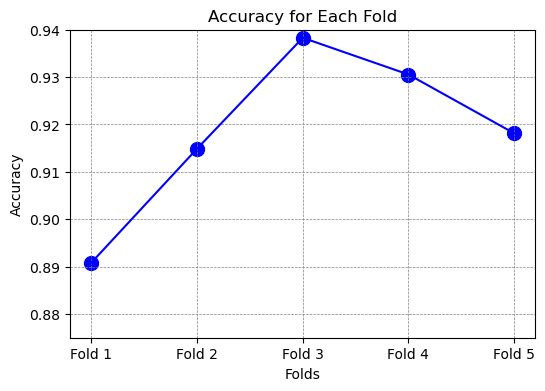

In [15]:
fold_labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

plt.figure(figsize=(6, 4))
plt.plot(fold_labels, fold_mean_accuracies, color='blue')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Fold')
plt.ylim(0.875, 0.94)  # Set the y-axis limits for better visualization
plt.grid(True, axis='both', linestyle='--', linewidth=0.5, color='gray')  # Add grid lines

# Add dots on each point
plt.scatter(fold_labels, fold_mean_accuracies, color='blue', marker='o', s=100)
plt.show()